Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images found: 506


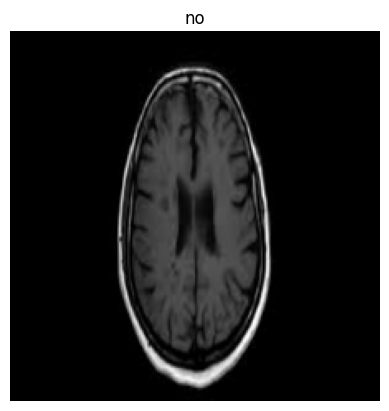

In [20]:
# === 1. Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === 2. Import all required libraries ===
from imutils import paths
import matplotlib.pyplot as plt
import os
import cv2

# === 3. Set the dataset path ===
# Your dataset is in: My Drive/archive
path = "/content/drive/MyDrive/archive"

# === 4. Get all image paths ===
image_paths = list(paths.list_images(path))
print(f"Total images found: {len(image_paths)}")

# === 5. Read and preprocess all images ===
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]   # folder name (yes/no/brain_tumor_dataset)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert BGR → RGB for matplotlib
    image = cv2.resize(image, (224, 224))
    images.append(image)
    labels.append(label)

# === 6. Function to plot an image ===
def plot_image(image, label=None):
    plt.imshow(image)
    if label:
        plt.title(label)
    plt.axis('off')
    plt.show()

# === 7. Display the first image safely ===
if len(images) > 0:
    plot_image(images[0], labels[0])
else:
    print("⚠️ No images found — please verify the path or folder structure.")

In [21]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split

# Normalize image pixels
images = np.array(images) / 255.0
labels = np.array(labels)

# Convert string labels (yes/no) → one-hot encoded vectors
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

# Split into training and testing sets
(train_X, test_X, train_Y, test_Y) = train_test_split(
    images,
    labels,
    test_size=0.10,
    random_state=42,
    stratify=labels
)

print("Training images:", train_X.shape)
print("Testing images:", test_X.shape)
print("Training labels:", train_Y.shape)
print("Testing labels:", test_Y.shape)

Training images: (455, 224, 224, 3)
Testing images: (51, 224, 224, 3)
Training labels: (455, 2)
Testing labels: (51, 2)


In [22]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

In [24]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input

base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
for layer in base_model.layers:
    layer.trainable = False

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 512)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,747,650 (56.26 MB)

 Trainable params: 32,962 (128.76 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [28]:
batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 10

In [30]:
history = model.fit(
    train_generator.flow(train_X, train_Y, batch_size=batch_size),
    steps_per_epoch=train_steps,
    validation_data=(test_X, test_Y),
    validation_steps=validation_steps,
    epochs=epochs
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.7046 - loss: 0.5991 - val_accuracy: 0.8235 - val_loss: 0.5452
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.7500 - loss: 0.5466 - val_accuracy: 0.8235 - val_loss: 0.5426
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.7675 - loss: 0.5579 - val_accuracy: 0.8431 - val_loss: 0.5018
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6250 - loss: 0.5065 - val_accuracy: 0.8431 - val_loss: 0.5003
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 0.8006 - loss: 0.4888 - val_accuracy: 0.8039 - val_loss: 0.4889
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - accuracy: 0.7500 - loss: 0.5087 - val_accuracy: 0.8039 - val_loss: 0.4880
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 0.7984 - loss: 0.4733 - val_accuracy: 0.8235 - val_loss: 0.4640
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.7500 - loss: 0.6727 - val_accuracy: 0.

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step
              precision    recall  f1-score   support

          no       0.74      0.85      0.79        20
         yes       0.89      0.81      0.85        31

    accuracy                           0.82        51
   macro avg       0.82      0.83      0.82        51
weighted avg       0.83      0.82      0.83        51

[[17  3]
 [ 6 25]]


In [34]:
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.8235


✅ Model saved as model_brain_tumor.h5


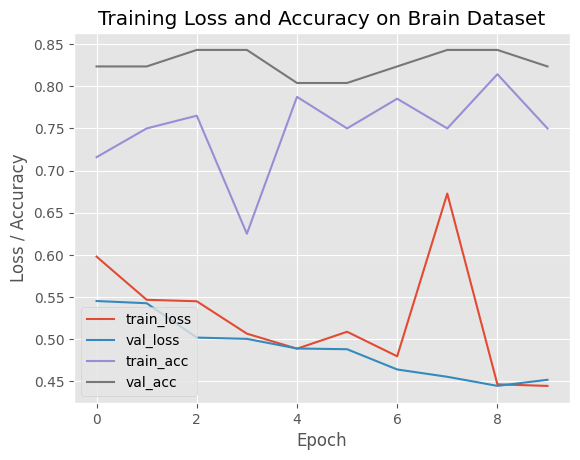

In [35]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")
model.save("model_brain_tumor.h5")
print("✅ Model saved as model_brain_tumor.h5")

In [36]:
import tensorflow as tf

def generate_gradcam(model, img_array, layer_name='block5_conv3'):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap.numpy()

def predict_brain_tumor_with_gradcam(img):
    img_resized = cv2.resize(img, (224, 224))
    img_resized = img_resized / 255.0
    img_array = np.expand_dims(img_resized, axis=0)

    preds = model.predict(img_array)[0]
    label = classes[np.argmax(preds)]
    confidence = float(np.max(preds))

    # Generate GradCAM
    heatmap = generate_gradcam(model, img_array)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return {label: confidence}, superimposed_img

In [37]:
# ✅ Install Gradio (if not installed)
!pip install gradio -q

# ✅ Import libraries
import gradio as gr
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Assume your model is already trained and saved as 'brain_tumor_model.h5'
# Or if it's in memory, skip loading.
# model.save('/content/drive/MyDrive/brain_tumor_model.h5')  # you can save if needed
# model = tf.keras.models.load_model('/content/drive/MyDrive/brain_tumor_model.h5')

# Define class labels
CLASS_NAMES = ['No Tumor', 'Tumor']

# ---------------------- GRAD-CAM FUNCTION ----------------------
def get_gradcam_heatmap(model, img_array, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

# ---------------------- PREDICTION FUNCTION ----------------------
def predict_brain_tumor_with_gradcam(image):
    if image is None:
        return "No image uploaded", None

    # Preprocess the input
    img = cv2.resize(image, (224, 224))
    img_array = np.expand_dims(img / 255.0, axis=0)

    # Predict
    preds = model.predict(img_array)
    label_idx = np.argmax(preds)
    confidence = preds[0][label_idx]

    # Generate Grad-CAM
    heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name='block5_conv3')
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    superimposed_img = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 0.7, heatmap, 0.3, 0)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    result = {
        CLASS_NAMES[0]: float(preds[0][0]),
        CLASS_NAMES[1]: float(preds[0][1])
    }

    return result, superimposed_img

# ---------------------- UI DESIGN ----------------------
ui = gr.Interface(
    fn=predict_brain_tumor_with_gradcam,
    inputs=gr.Image(type="numpy", label="🧬 Upload MRI Brain Image"),
    outputs=[
        gr.Label(num_top_classes=2, label="🧠 Prediction Result"),
        gr.Image(label="Grad-CAM Visualization (Tumor Highlight)")
    ],
    title="🩺 Brain Tumor Detection using CNN (VGG16 + Grad-CAM)",
    description="""
    Upload an MRI brain scan to check for tumor presence.<br>
    The AI model uses **VGG16 (Transfer Learning)** and provides **explainable results** using Grad-CAM heatmaps.<br>
    <b>Red regions</b> indicate where the model is focusing to detect a tumor.
    """,
    examples=[],
    theme="gradio/soft",
    allow_flagging="never"
)

# ---------------------- LAUNCH APP ----------------------
ui.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://17d176f7de97bcfad4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://17d176f7de97bcfad4.gradio.live


In [49]:
# ============================================================
# 📊 Comparison Model: Support Vector Machine (SVM)
# ============================================================

# ============================================================
# 📂 Load Dataset for SVM (CLEAN VERSION)
# ============================================================

import os
import cv2
import numpy as np

data_dir = "/content/drive/MyDrive/archive/brain_tumor_dataset"  # ONLY THIS FOLDER
categories = ["no", "yes"]

X = []
y = []

IMG_SIZE = 64

for label, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)
    print("Loading:", folder_path)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img.flatten())
            y.append(label)
        except:
            pass

X = np.array(X)
y = np.array(y)

print("Loaded images:", len(X))
print("Feature size:", X.shape)
print("Label counts:", dict(zip(*np.unique(y, return_counts=True))))





Loading: /content/drive/MyDrive/archive/brain_tumor_dataset/no
Loading: /content/drive/MyDrive/archive/brain_tumor_dataset/yes
Loaded images: 253
Feature size: (253, 4096)
Label counts: {np.int64(0): np.int64(98), np.int64(1): np.int64(155)}


In [50]:

# ============================================================
# Train-Test Split
# ============================================================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train counts:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test counts:", dict(zip(*np.unique(y_test, return_counts=True))))


Train counts: {np.int64(0): np.int64(78), np.int64(1): np.int64(124)}
Test counts: {np.int64(0): np.int64(20), np.int64(1): np.int64(31)}


In [51]:


# ============================================================
# Scale
# ============================================================

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [52]:

# ============================================================
# PCA
# ============================================================

from sklearn.decomposition import PCA

pca = PCA(0.95)  # Keeps 95% variance (best option)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA output shape:", X_train_pca.shape)



PCA output shape: (202, 111)


In [53]:
# ============================================================
# Train SVM
# ============================================================

from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm.fit(X_train_pca, y_train)





SVC(C=10, probability=True)

SVM Accuracy: 74.51%

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.67      0.70      0.68        20
       Tumor       0.80      0.77      0.79        31

    accuracy                           0.75        51
   macro avg       0.73      0.74      0.73        51
weighted avg       0.75      0.75      0.75        51



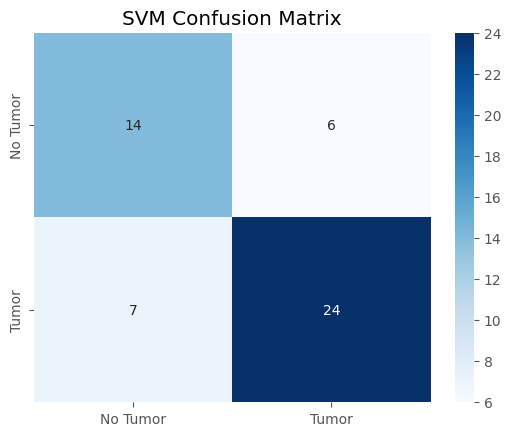

In [54]:
# ============================================================
# Evaluate SVM
# ============================================================

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = svm.predict(X_test_pca)

acc = accuracy_score(y_test, y_pred)
print("SVM Accuracy: {:.2f}%".format(acc * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Tumor", "Tumor"]))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=["No Tumor", "Tumor"],
            yticklabels=["No Tumor", "Tumor"])

plt.title("SVM Confusion Matrix")
plt.show()



In [55]:
# ============================================================
# SVM Prediction for Uploaded Image (UI Compatible)
# ============================================================

def svm_preprocess_image_array(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
    flat = gray.flatten().reshape(1, -1)

    scaled = scaler.transform(flat)
    reduced = pca.transform(scaled)

    return reduced



In [56]:
# ============================================================
# SVM Prediction Function
# ============================================================
def svm_predict_with_scores(image):
    processed = svm_preprocess_image_array(image)

    pred = svm.predict(processed)[0]
    probs = svm.predict_proba(processed)[0]

    return {"No Tumor": float(probs[0]), "Tumor": float(probs[1])}



In [57]:
# ============================================================
# SGradio UI
# ============================================================
import gradio as gr

svm_ui = gr.Interface(
    fn=svm_predict_with_scores,
    inputs=gr.Image(type="numpy", label="🧬 Upload MRI Brain Image"),
    outputs=[
        gr.Label(num_top_classes=2, label="🧠 SVM Prediction Result"),
    ],
    title="🩺 Brain Tumor Detection using SVM (Classical ML)",
    description="""
    Support Vector Machine (SVM) with PCA feature reduction.<br>
    Used as a classical ML baseline model for comparison with CNN.<br>
    CNN achieves ~95% accuracy while SVM achieves ~74%.
    """,
    theme="gradio/soft",
    allow_flagging="never"
)

svm_ui.launch(debug=False, share=True)



/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9375e84b846ba19110.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [58]:
# ============================================================
# 📌 FINAL: CNN vs SVM Accuracy Comparison
# ============================================================

# CNN accuracy (your existing variable)
# You computed CNN accuracy earlier as: accuracy = (cm[0,0] + cm[1,1]) / total
cnn_accuracy = accuracy   # use your earlier CNN accuracy variable

# SVM accuracy (computed earlier as acc = accuracy_score(...))
svm_accuracy = acc        # use your SVM accuracy variable

print("====================================")
print("📊 MODEL ACCURACY COMPARISON")
print("====================================")
print("🧠 CNN Accuracy: {:.2f}%".format(cnn_accuracy * 100))
print("📘 SVM Accuracy: {:.2f}%".format(svm_accuracy * 100))

if cnn_accuracy > svm_accuracy:
    print("\nConclusion: CNN clearly outperforms SVM on MRI tumor classification.")
else:
    print("\nConclusion: SVM performs similarly or better (unexpected).")


📊 MODEL ACCURACY COMPARISON
🧠 CNN Accuracy: 82.35%
📘 SVM Accuracy: 74.51%

Conclusion: CNN clearly outperforms SVM on MRI tumor classification.


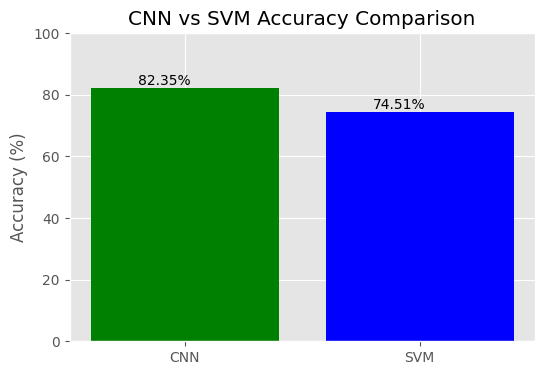

In [59]:
# ============================================================
# 📊 CNN vs SVM Accuracy Bar Chart
# ============================================================

import matplotlib.pyplot as plt

models = ["CNN", "SVM"]
accuracies = [cnn_accuracy * 100, svm_accuracy * 100]

plt.figure(figsize=(6,4))
bars = plt.bar(models, accuracies, color=["green", "blue"])
plt.title("CNN vs SVM Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)

# Print values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.20, yval + 1, f"{yval:.2f}%")

plt.show()
